In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import ast
from tqdm import tqdm
from collections import defaultdict
from pymicro.view.vol_utils import compute_affine_transform

HOME = os.path.expanduser("~")
PATH = os.path.join(HOME, 'programming/pipeline_utility')
sys.path.append(PATH)
from utilities.sqlcontroller import SqlController
from utilities.file_location import FileLocationManager
from utilities.utilities_cvat_neuroglancer import get_structure_number, NumpyToNeuroglancer, get_segment_properties


Connecting dklab@192.168.1.12:3306


In [2]:
# install these
#https://pymicro.readthedocs.io/projects/pymicro/en/latest/cookbook/pointset_registration.html
from pymicro.view.vol_utils import compute_affine_transform
#https://pypi.org/project/affine6p/
import affine6p
#https://github.com/jewettaij/superpose3d
from superpose3d import Superpose3D

In [3]:
HOME = os.path.expanduser("~")
DIR = os.path.join(HOME, 'programming/pipeline_utility')
sys.path.append(DIR)
from utilities.contour_utilities import get_contours_from_annotations, add_structure_to_neuroglancer, \
    create_full_volume, get_structure_colors
from utilities.sqlcontroller import SqlController
animal = 'MD589'
sqlController = SqlController(animal)

CSV_PATH = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data/foundation_brain_annotations'
csvfile = os.path.join(CSV_PATH, 'MD589_annotation.csv')
hand_annotations = pd.read_csv(csvfile)
hand_annotations.head()
hand_annotations['vertices'] = hand_annotations['vertices'] \
    .apply(lambda x: x.replace(' ', ','))\
    .apply(lambda x: x.replace('\n',','))\
    .apply(lambda x: x.replace(',]',']'))\
    .apply(lambda x: x.replace(',,', ','))\
    .apply(lambda x: x.replace(',,', ','))\
    .apply(lambda x: x.replace(',,', ',')).apply(lambda x: x.replace(',,', ','))

hand_annotations['vertices'] = hand_annotations['vertices'].apply(lambda x: ast.literal_eval(x))
structures = ['DC', 'LC','SC', '5N', '7n']
# SC is the only singular structure
df = hand_annotations[['name', 'section', 'side', 'vertices']].copy()
df = df.loc[df['name'].isin(structures)]
df = df.reset_index()
df = df.sort_values(by=['name', 'section'])
df.head()

,index,name,section,side,vertices
191,843,5N,150,L,"[[23467.35736638, 13029.96696407], [23371.8771..."
369,1683,5N,151,L,"[[22119.53951512, 14078.59777646], [21969.6072..."
451,2089,5N,152,L,"[[23441.88459431, 13586.7746992], [23299.53025..."
116,489,5N,153,L,"[[22705.00744451, 13825.99679013], [22571.2393..."
49,198,5N,154,L,"[[22703.58621367, 14048.8018496], [22552.64526..."


In [160]:
# these are the 5 structures Beth suggested for getting
# enough that were spread out.
structures = ['DC', 'LC','SC', '5N', '7n']
centers = {}
section_structure_vertices = defaultdict(dict)
SC = df.loc[(df['name'] == "SC")]
first_section = SC['section'].min()
last_section = SC['section'].max()
midsection = int(round(((last_section + first_section) / 2)))
point_array = SC['vertices'].loc[SC['section'] == midsection].values
section_structure_vertices[midsection]['SC'] = point_array[0]
cx, cy = np.mean(point_array[0], axis=0)    
centers['SC'] = [int(round(cx)), int(round(cy)), int(round(midsection))]

structures.remove('SC')
for structure in structures:
    df_tmp = df.loc[(df['name'] == structure) & (df['side'] == "L")]
    first_section = df_tmp['section'].min()
    last_section = df_tmp['section'].max()
    midsection = int(round(((last_section + first_section) / 2)))
    structure_name = structure + "_L"
    point_array = df_tmp['vertices'].loc[df_tmp['section'] == midsection].values
    section_structure_vertices[midsection][structure_name] = point_array[0]
    cx, cy = np.mean(point_array[0], axis=0)    
    centers[structure_name] = [int(round(cx)), int(round(cy)), int(round(midsection))]
    
    df_tmp = df.loc[(df['name'] == structure) & (df['side'] == "R")]
    first_section = df_tmp['section'].min()
    last_section = df_tmp['section'].max()
    midsection = int(round(((last_section - first_section) / 2) + first_section))
    structure_name = structure + "_R"
    point_array = df_tmp['vertices'].loc[df_tmp['section'] == midsection].values
    section_structure_vertices[midsection][structure_name] = point_array[0]
    cx, cy = np.mean(point_array[0], axis=0)    
    centers[structure_name] = [int(round(cx)), int(round(cy)), int(round(midsection))]


In [5]:
centers

{'SC': [24226, 6401, 220],
 'DC_L': [24482, 11985, 134],
 'DC_R': [20424, 11736, 330],
 'LC_L': [25290, 11750, 180],
 'LC_R': [24894, 12079, 268],
 '5N_L': [23790, 13025, 160],
 '5N_R': [20805, 14163, 298],
 '7n_L': [20988, 18405, 177],
 '7n_R': [24554, 13911, 284]}

In [6]:
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
thickness = 1
colors = {}
colors['SC'] = (255,0,255)

colors['DC_L'] = (0,0,0)
colors['LC_L'] = (255,0,0)
colors['SC_L'] = (255,0,255)
colors['5N_L'] = (0,255,255)
colors['7n_L'] = (100,10,255)
colors['DC_R'] = (0,0,0)
colors['LC_R'] = (255,0,0)
colors['SC_R'] = (255,0,255)
colors['5N_R'] = (0,255,255)
colors['7n_R'] = (100,10,255)
# create a fake random distance away from the original structures
rand_offset = np.random.randint(75,150)
offsets = {}
section_images = {}
points = {}
SCALE = 32
PATH = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps/CH1'
thumbnail_dir = os.path.join(PATH, 'thumbnail')
files = sorted(os.listdir(thumbnail_dir))
for file_name in tqdm(files):
    filepath = os.path.join(thumbnail_dir, file_name)
    img = cv2.imread(filepath)
    section = int(file_name.split('.')[0])
    
    for structure in section_structure_vertices[section]:
        pts = section_structure_vertices[section][structure]
        points = np.array(pts, dtype=np.int32)        
        points = points // SCALE
        
        points_diff = np.rint(points + rand_offset)
        points_diff = points_diff.astype(np.int32)
        cxoff, cyoff = np.min(points_diff, axis=0)
        offsets[structure] = [int(round(cxoff*SCALE)), int(round(cyoff*SCALE)), section]
        
        #cv2.polylines(img, [points_diff], isClosed=True, color=(0,0,0), thickness=5)
        cx = centers[structure][0] // SCALE
        cy = centers[structure][1] // SCALE
        
        cv2.circle(img, (cx,cy), 10, (0,0,0), -1)
            
        cv2.polylines(img, [points], isClosed=True, color=colors[structure], thickness=2)
        cv2.putText(img, structure, (cx,cy), font,
                    fontScale, colors[structure], thickness, cv2.LINE_AA)
            
    section_images[section] = img

100%|██████████| 448/448 [00:06<00:00, 68.04it/s] 


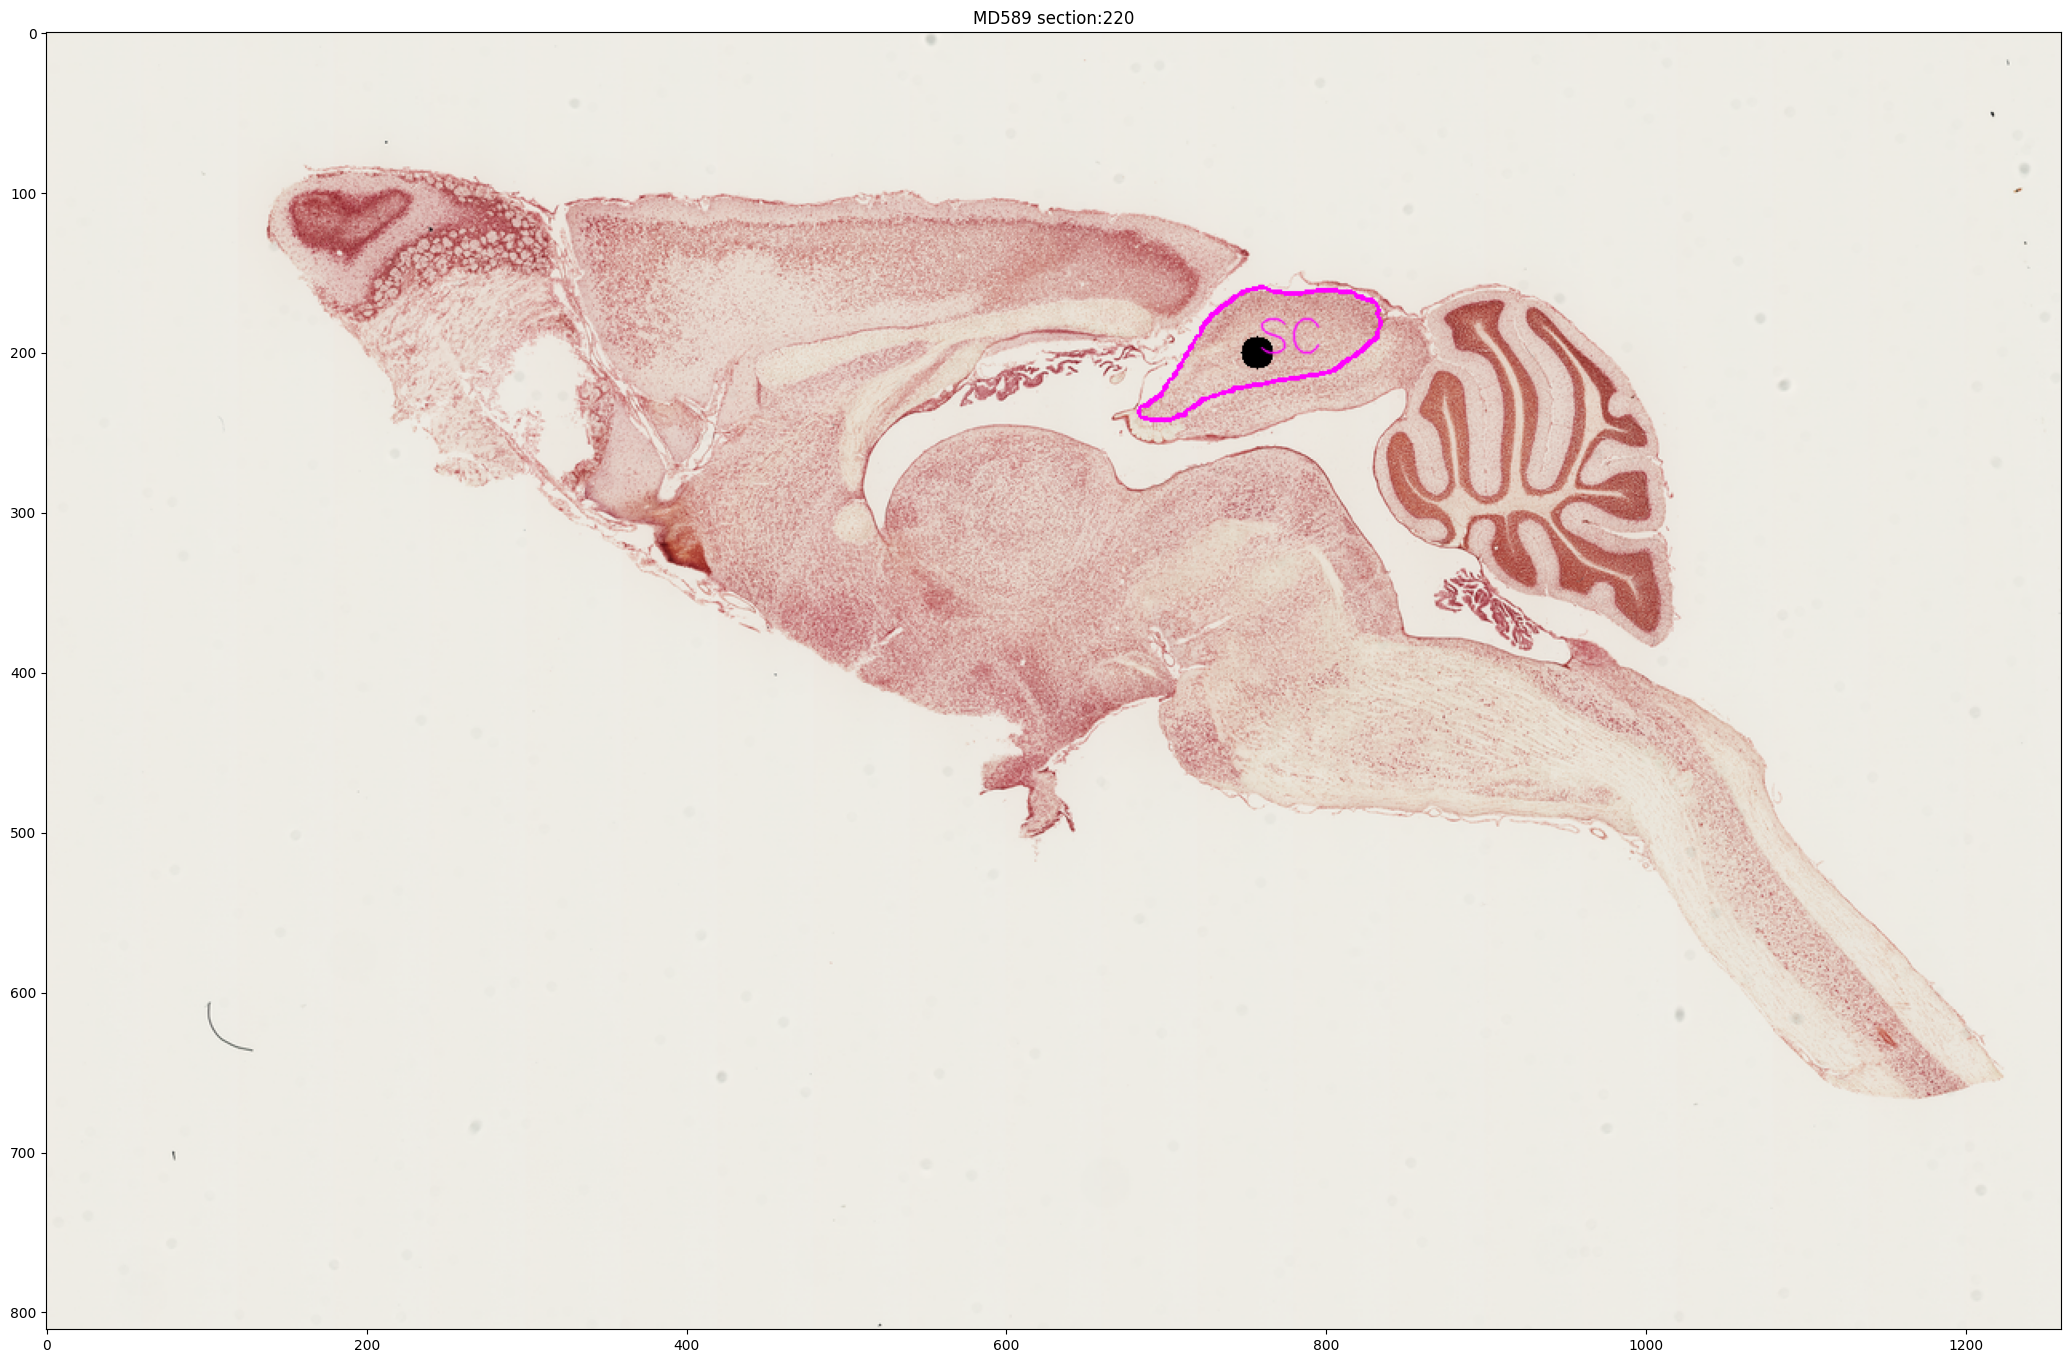

In [157]:
# this shows the real structure, it's center of mass and a fake offsetted structure
structure_midpoints = [134,160,177,180,220,268,284,298,330]
section = structure_midpoints[4]
fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(section_images[section], cmap="cool")
plt.title('{} section:{}'.format(animal, section))
plt.show()

In [10]:
origin_centroid = np.mean(origin, axis=0)
fitted_centroid = np.mean(fitted, axis=0)
print(origin_centroid, fitted_centroid, other_structure)

[23272.555   12606.111     227.88889] [27249.777   16714.666     227.88889] (25000, 15000, 200)


In [ ]:
# Pad the data with ones, so that our transformation can do translations too
n = origin.shape[0]
pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
unpad = lambda x: x[:,:-1]
X = pad(origin)
Y = pad(fitted)

# Solve the least squares problem X * A = Y
# to find our transformation matrix A
A, res, rank, s = np.linalg.lstsq(X, Y)

transform = lambda x: unpad(np.dot(pad(x), A))

print("Target:", fitted)
print("Result:", transform(origin))
print("Max error:", np.abs(fitted - transform(origin)).max())

In [11]:
def Affine_Fit( from_pts, to_pts ):
    """Fit an affine transformation to given point sets.
      More precisely: solve (least squares fit) matrix 'A'and 't' from
      'p ~= A*q+t', given vectors 'p' and 'q'.
      Works with arbitrary dimensional vectors (2d, 3d, 4d...).

      Written by Jarno Elonen <elonen@iki.fi> in 2007.
      Placed in Public Domain.

      Based on paper "Fitting affine and orthogonal transformations
      between two sets of points, by Helmuth Späth (2003)."""

    q = from_pts
    p = to_pts
    if len(q) != len(p) or len(q)<1:
        print("from_pts and to_pts must be of same size.")
        return false

    dim = len(q[0]) # num of dimensions
    if len(q) < dim:
        print("Too few points => under-determined system.")
        return false

    # Make an empty (dim) x (dim+1) matrix and fill it
    c = [[0.0 for a in range(dim)] for i in range(dim+1)]
    for j in range(dim):
        for k in range(dim+1):
            for i in range(len(q)):
                qt = list(q[i]) + [1]
                c[k][j] += qt[k] * p[i][j]

    # Make an empty (dim+1) x (dim+1) matrix and fill it
    Q = [[0.0 for a in range(dim)] + [0] for i in range(dim+1)]
    for qi in q:
        qt = list(qi) + [1]
        for i in range(dim+1):
            for j in range(dim+1):
                Q[i][j] += qt[i] * qt[j]

    # Ultra simple linear system solver. Replace this if you need speed.
    def gauss_jordan(m, eps = 1.0/(10**10)):
      """Puts given matrix (2D array) into the Reduced Row Echelon Form.
         Returns True if successful, False if 'm' is singular.
         NOTE: make sure all the matrix items support fractions! Int matrix will NOT work!
         Written by Jarno Elonen in April 2005, released into Public Domain"""
      (h, w) = (len(m), len(m[0]))
      for y in range(0,h):
        maxrow = y
        for y2 in range(y+1, h):    # Find max pivot
          if abs(m[y2][y]) > abs(m[maxrow][y]):
            maxrow = y2
        (m[y], m[maxrow]) = (m[maxrow], m[y])
        if abs(m[y][y]) <= eps:     # Singular?
          return False
        for y2 in range(y+1, h):    # Eliminate column y
          c = m[y2][y] / m[y][y]
          for x in range(y, w):
            m[y2][x] -= m[y][x] * c
      for y in range(h-1, 0-1, -1): # Backsubstitute
        c  = m[y][y]
        for y2 in range(0,y):
          for x in range(w-1, y-1, -1):
            m[y2][x] -=  m[y][x] * m[y2][y] / c
        m[y][y] /= c
        for x in range(h, w):       # Normalize row y
          m[y][x] /= c
      return True

    # Augement Q with c and solve Q * a' = c by Gauss-Jordan
    M = [ Q[i] + c[i] for i in range(dim+1)]
    if not gauss_jordan(M):
        print("Error: singular matrix. Points are probably coplanar.")
        return false

    # Make a result object
    class Transformation:
        """Result object that represents the transformation
           from affine fitter."""

        def To_Str(self):
            res = ""
            for j in range(dim):
                str = "x%d' = " % j
                for i in range(dim):
                    str +="x%d * %f + " % (i, M[i][j+dim+1])
                str += "%f" % M[dim][j+dim+1]
                res += str + "\n"
            return res

        def Transform(self, pt):
            res = [0.0 for a in range(dim)]
            for j in range(dim):
                for i in range(dim):
                    res[j] += pt[i] * M[i][j+dim+1]
                res[j] += M[dim][j+dim+1]
            return res
    return Transformation()

In [ ]:
fitted

In [ ]:
from_pt = origin / 32
to_pt = fitted / 32
trn = Affine_Fit(from_pt, to_pt)
print("Transformation is:")
print(trn.To_Str())

err = 0.0
for i in range(len(from_pt)):
    fp = from_pt[i]
    tp = to_pt[i]
    t = trn.Transform(fp)
    print(t)
    #print ("%s => %s ~= %s" % (fp, tuple(t), tp))
    err += ((tp[0] - t[0])**2 + (tp[1] - t[1])**2)**0.5

print("Fitting error = %f" % err)

In [177]:
SCALE = (10 / 0.452)
MD589_centers = {'SC': [24226, 6401, 220],
     'DC_L': [24482, 11985, 134],
     'DC_R': [20424, 11736, 330],
     'LC_L': [25290, 11750, 180],
     'LC_R': [24894, 12079, 268],
     '5N_L': [23790, 13025, 160],
     '5N_R': [20805, 14163, 298],
     '7n_L': [20988, 18405, 177],
     '7n_R': [24554, 13911, 284]}
MD589_center_values = np.array(list(MD589_centers.values()), dtype=np.float32)
MD589_list = []
for value in MD589_centers.values():
    MD589_list.append((value[0]/SCALE, value[1]/SCALE, value[2]))

MD589_center_values = np.array(MD589_list)
MD589_center_values

array([[1095.0152,  289.3252,  220.    ],
       [1106.5864,  541.722 ,  134.    ],
       [ 923.1648,  530.4672,  330.    ],
       [1143.108 ,  531.1   ,  180.    ],
       [1125.2088,  545.9708,  268.    ],
       [1075.308 ,  588.73  ,  160.    ],
       [ 940.386 ,  640.1676,  298.    ],
       [ 948.6576,  831.906 ,  177.    ],
       [1109.8408,  628.7772,  284.    ]])

In [178]:
atlas_centers = {'5N_L': [460.53, 685.58, 155],
 '5N_R': [460.53, 685.58, 293],
 '7n_L': [499.04, 729.94, 172],
 '7n_R': [499.04, 729.94, 276],
 'DC_L': [580.29, 650.66, 130],
 'DC_R': [580.29, 650.66, 318],
 'LC_L': [505.55, 629.99, 182],
 'LC_R': [505.55, 629.99, 266],
 'SC': [376.87, 453.2, 226]}
atlas_center_values = np.array(list(atlas_centers.values()))
atlas_center_values

array([[460.53, 685.58, 155.  ],
       [460.53, 685.58, 293.  ],
       [499.04, 729.94, 172.  ],
       [499.04, 729.94, 276.  ],
       [580.29, 650.66, 130.  ],
       [580.29, 650.66, 318.  ],
       [505.55, 629.99, 182.  ],
       [505.55, 629.99, 266.  ],
       [376.87, 453.2 , 226.  ]])

In [ ]:
A[np.abs(A) < 1e-2] = 0  # set really small values to zero
print(A)

In [ ]:
RMSD, R, T, c = Superpose3D(origin, fitted)

In [179]:
print(other_structure)
origin_centroid + np.dot(R, other_structure - fitted_centroid)

(25000, 15000, 200)


array([24107.73572998, 14977.62220826,  1524.33178944])

In [181]:
# compute the affine transform from the point set
translation, transformation = compute_affine_transform(MD589_center_values, atlas_center_values)
invt = np.linalg.inv(transformation)
offset = -np.dot(invt, translation)
#print(other_structure, origin_centroid + np.dot(transformation, other_structure - fitted_centroid))
translation

array([1098.91337678,  587.06603124,  549.0182624 ])

In [ ]:
origin_centroid = np.mean(origin, axis=0)
fitted_centroid = np.mean(fitted, axis=0)
colors = 'brg'
new_points = np.empty_like(origin)
fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')

for i in range(len(origin)):
    new_points[i] = origin_centroid + np.dot(transformation, fitted[i] - fitted_centroid)
    print('point %d will move to (%3.1f, %3.1f) to be compared with (%3.1f, %3.1f)' % (
    i, new_points[i, 0], new_points[i, 1], origin[i, 0], origin[i, 1]))
    plt.plot(new_points[i, 0], new_points[i, 1], 'x', color=colors[0], markersize=14,
             label='new points' if i == 0 else '')
    plt.plot(origin[i, 0], origin[i, 1], 'o', color=colors[1], markersize=16,
             label='origin' if i == 0 else '')
    plt.plot(fitted[i, 0], fitted[i, 1], 'v', color=colors[2], markersize=18,
             label='atlas' if i == 0 else '')
plt.legend(numpoints=1)
plt.show()


In [130]:
fileLocationManager = FileLocationManager(animal)
atlas_name = 'atlasV7'
DATA_PATH = '/net/birdstore/Active_Atlas_Data/data_root'
ROOT_DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data'
THUMBNAIL_DIR = os.path.join(ROOT_DIR, animal, 'preps', 'CH1', 'thumbnail')
ATLAS_PATH = os.path.join(DATA_PATH, 'atlas_data', atlas_name)
ORIGIN_PATH = os.path.join(ATLAS_PATH, 'origin')
VOLUME_PATH = os.path.join(ATLAS_PATH, 'structure')
OUTPUT_DIR = os.path.join(fileLocationManager.neuroglancer_data, 'atlas')
os.makedirs(OUTPUT_DIR, exist_ok=True)
SCALE = 32
origin_files = sorted(os.listdir(ORIGIN_PATH))
volume_files = sorted(os.listdir(VOLUME_PATH))

structure_volume_origin = {}
for volume_filename, origin_filename in zip(volume_files, origin_files):
    structure = os.path.splitext(volume_filename)[0]
    if structure not in origin_filename:
        print(structure, origin_filename)
        break

    color = get_structure_number(structure.replace('_L', '').replace('_R', ''))

    origin = np.loadtxt(os.path.join(ORIGIN_PATH, origin_filename))
    volume = np.load(os.path.join(VOLUME_PATH, volume_filename))

    volume = np.rot90(volume, axes=(0, 1))
    volume = np.flip(volume, axis=0)
    volume[volume > 0.8] = color
    volume = volume.astype(np.uint8)

    structure_volume_origin[structure] = (volume, origin)
sqlController = SqlController(animal)
resolution = sqlController.scan_run.resolution
aligned_shape = np.array((sqlController.scan_run.width, sqlController.scan_run.height))
z_length = len(os.listdir(THUMBNAIL_DIR))

downsampled_aligned_shape = np.round(aligned_shape / SCALE).astype(int)

x_length = downsampled_aligned_shape[1]
y_length = downsampled_aligned_shape[0]

atlasV7_volume = np.zeros((x_length, y_length, z_length), dtype=np.uint32)

min_structures = {'SC': [21868, 5119, 220],
                  'DC_L': [24103, 11618, 134],
                  'DC_R': [19870, 11287, 330],
                  'LC_L': [24746, 11178, 180],
                  'LC_R': [24013, 11621, 268],
                  '5N_L': [23105, 12133, 160],
                  '5N_R': [20205, 13373, 298],
                  '7n_L': [20611, 17991, 177],
                  '7n_R': [24218, 13615, 284]}

mean_structures = {'SC': [24226, 6401, 220],
                   'DC_L': [24482, 11985, 134],
                   'DC_R': [20424, 11736, 330],
                   'LC_L': [25290, 11750, 180],
                   'LC_R': [24894, 12079, 268],
                   '5N_L': [23790, 13025, 160],
                   '5N_R': [20805, 14163, 298],
                   '7n_L': [20988, 18405, 177],
                   '7n_R': [24554, 13911, 284]}

animal_origin = {}
for structure, origin in mean_structures.items():
    animal_origin[structure] = [mean_structures[structure][1]/SCALE,
                                    mean_structures[structure][0]/SCALE,
                                    mean_structures[structure][2]]

atlas_origin = {}
atlas_all_origins = {}

print('animal_origin', animal_origin)
# 1st loop to fill dictionarys with data
for structure, (volume, origin) in sorted(structure_volume_origin.items()):
    x, y, z = origin
    x_start = int(x) + x_length // 2
    y_start = int(y) + y_length // 2
    z_start = int(z) // 2 + z_length // 2
    x_end = x_start + volume.shape[0]
    y_end = y_start + volume.shape[1]
    z_end = z_start + (volume.shape[2] + 1) // 2
    midx = round((x_end + x_start) / 2)
    midy = round((y_end + y_start) / 2)
    midz = round((z_end + z_start) / 2)
    #print(structure,'centroid', midx,midy,midz)

    if structure in animal_origin.keys():
        atlas_origin[structure] = [midx, midy, midz]

    atlas_all_origins[structure] = [midx, midy, midz]

print('atlas_origin', atlas_origin)
print()

atlas_origin_array = np.array(list(atlas_origin.values()), dtype=np.float32)
animal_origin_array = np.array(list(animal_origin.values()), dtype=np.float32)
animal_centroid = np.mean(animal_origin_array, axis=0)
atlas_centroid = np.mean(atlas_origin_array, axis=0)
print('volume centriods', animal_centroid, atlas_centroid)
print('animal_origin_array', animal_origin_array.shape)
print(animal_origin_array)
print('atlas_origin_array', atlas_origin_array.shape)
print(atlas_origin_array)

animal_origin {'SC': [200.03125, 757.0625, 220], 'DC_L': [374.53125, 765.0625, 134], 'DC_R': [366.75, 638.25, 330], 'LC_L': [367.1875, 790.3125, 180], 'LC_R': [377.46875, 777.9375, 268], '5N_L': [407.03125, 743.4375, 160], '5N_R': [442.59375, 650.15625, 298], '7n_L': [575.15625, 655.875, 177], '7n_R': [434.71875, 767.3125, 284]}
atlas_origin {'5N_L': [462.0, 686.0, 156], '5N_R': [462.0, 686.0, 293], '7n_L': [500.0, 730.0, 172], '7n_R': [500.0, 730.0, 276], 'DC_L': [580.0, 651.0, 131], 'DC_R': [580.0, 651.0, 318], 'LC_L': [506.0, 630.0, 183], 'LC_R': [506.0, 630.0, 266], 'SC': [377.0, 454.0, 226]}

volume centriods [393.94098 727.26733 227.88889] [497.      649.7778  224.55556]
animal_origin_array (9, 3)
[[200.03125 757.0625  220.     ]
 [374.53125 765.0625  134.     ]
 [366.75    638.25    330.     ]
 [367.1875  790.3125  180.     ]
 [377.46875 777.9375  268.     ]
 [407.03125 743.4375  160.     ]
 [442.59375 650.15625 298.     ]
 [575.15625 655.875   177.     ]
 [434.71875 767.3125  2

In [158]:
from pprint import pprint
pprint(animal_origin_array)

array([[200.03125, 757.0625 , 220.     ],
       [374.53125, 765.0625 , 134.     ],
       [366.75   , 638.25   , 330.     ],
       [367.1875 , 790.3125 , 180.     ],
       [377.46875, 777.9375 , 268.     ],
       [407.03125, 743.4375 , 160.     ],
       [442.59375, 650.15625, 298.     ],
       [575.15625, 655.875  , 177.     ],
       [434.71875, 767.3125 , 284.     ]], dtype=float32)


In [151]:
RMSD, R, T, c = Superpose3D(animal_origin_array, atlas_origin_array, allow_rescale=True)
T

array([1020.33379431, 1722.52411859, 1437.26120571])

In [145]:
T

array([1020.33379431, 1722.52411859, 1437.26120571])

In [30]:
# basic least squares
n = animal_origin_array.shape[0]
pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
unpad = lambda x: x[:, :-1]
X = pad(animal_origin_array)
Y = pad(atlas_origin_array)

# Solve the least squares problem X * A = Y
# to find our transformation matrix A
A, residuals, rank, s = np.linalg.lstsq(X, Y, rcond=None)
transform = lambda x: unpad(np.dot(pad(x), A))
#A[np.abs(A) < 1e-10] = 0
print(A)

[[-1.59528578e-02 -6.04842017e-01  2.34864375e-01  1.26153178e-16]
 [-2.20118640e-01 -9.16312862e-01  1.54768813e-03  1.99493200e-16]
 [-2.17851397e-01 -6.74645796e-01 -7.27233727e-01 -8.58959171e-16]
 [ 7.13015500e+02  1.70819855e+03  2.96635758e+02  1.00000000e+00]]


In [31]:
a = X.T
#np.vstack([animal_origin_array, np.ones(len(animal_origin_array))])
#a = np.vstack([animal_origin_array, np.ones(len(animal_origin_array))]).T
Ap = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, Y))
print(Ap)

[[-1.59528578e-02 -6.04842017e-01  2.34864375e-01 -1.83880688e-16]
 [-2.20118640e-01 -9.16312862e-01  1.54768813e-03  0.00000000e+00]
 [-2.17851397e-01 -6.74645796e-01 -7.27233727e-01 -1.38777878e-17]
 [ 7.13015500e+02  1.70819855e+03  2.96635758e+02  1.00000000e+00]]


In [41]:
App = np.linalg.lstsq(X, Y, rcond=None)[0]
print(App)

[[-1.59528578e-02 -6.04842017e-01  2.34864375e-01  1.26153178e-16]
 [-2.20118640e-01 -9.16312862e-01  1.54768813e-03  1.99493200e-16]
 [-2.17851397e-01 -6.74645796e-01 -7.27233727e-01 -8.58959171e-16]
 [ 7.13015500e+02  1.70819855e+03  2.96635758e+02  1.00000000e+00]]


In [114]:
animal_origin = {'SC': [200.03125, 757.0625, 220], 'DC_L': [374.53125, 765.0625, 134], 'DC_R': [366.75, 638.25, 330]}
atlas_origin =  {'SC': [377.0, 454.0, 226], 'DC_L': [580.0, 651.0, 131], 'DC_R': [580.0, 651.0, 318]}
#primary = np.array(list(animal_origin.values()), dtype=np.float32)
#secondary = np.array(list(atlas_origin.values()), dtype=np.float32)
primary = animal_origin_array
secondary = atlas_origin_array

In [106]:
[1 for x in range(primary.shape[0])]


[1, 1, 1]

In [115]:
def solve_affine(rbar, rfit):
    x = np.transpose(np.matrix(rbar))
    y = np.transpose(np.matrix(rfit))
    # add ones on the bottom of x and y
    rows = rbar.shape[0]
    bottom = [1 for x in range(rows)]
    x = np.vstack((x,bottom))
    y = np.vstack((y,bottom))
    # solve for A2
    A2 = y * x.I
    # return function that takes input x and transforms it
    # don't need to return the 4th row as it is
    return lambda x: (A2*np.vstack((np.matrix(x).reshape(3,1),1)))[0:rows,:]
transformFn = solve_affine(primary, secondary)

In [112]:
def solve_affineXXX(rbar, rfit):
    x = np.transpose(rbar)
    y = np.transpose(rfit)
    # add ones on the bottom of x and y
    x = np.vstack((x,[1,1,1]))
    y = np.vstack((y,[1,1,1]))
    # solve for A2
    A2 = y * x.I
    # return function that takes input x and transforms it
    # don't need to return the 4th row as it is 
    return lambda x: (A2*np.vstack((np.matrix(x).reshape(3,1),1)))[0:3,:]
transformFn = solve_affine(primary, secondary)
SC1 = np.array([200.03125, 757.0625, 220])
SC2 = np.array([377.0, 454.0, 226])
# test: transform primary_system1 and we should get secondary_system1
result = np.matrix(SC2).T - transformFn(SC1)
np.linalg.norm(result)

# transform another point (x,y,z).
#transformed = transformFn((x,y,z))

1.0120682995173443e-12

In [136]:
n = primary.shape[0]
pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
unpad = lambda x: x[:,:-1]
X = pad(primary)
Y = pad(secondary)
# Solve the least squares problem X * A = Y
# to find our transformation matrix A
A, residuals, rank, s = np.linalg.lstsq(X, Y, rcond=None)
transform = lambda x: unpad(np.dot(pad(x), A))
print("Target:")
print(secondary)
print("Result:")
print(transform(primary))
print("Max error:", np.abs(secondary - transform(primary)).max())

Target:
[[462. 686. 156.]
 [462. 686. 293.]
 [500. 730. 172.]
 [500. 730. 276.]
 [580. 651. 131.]
 [580. 651. 318.]
 [506. 630. 183.]
 [506. 630. 266.]
 [377. 454. 226.]]
Result:
[[495.25355423 745.08306209 184.79624948]
 [509.44405158 690.22716564 288.33456499]
 [494.78310599 678.90294134 143.77294981]
 [493.98204544 640.49836781 253.1961074 ]
 [477.37107534 586.25037742 191.59508611]
 [508.02151297 672.84427501 277.02611151]
 [497.92363858 643.70827006 184.87585119]
 [520.91010345 639.9208773  304.01419176]
 [475.31091243 550.56466334 193.38888776]]
Max error: 102.62892465804657


In [137]:
var7nl = np.array([446,676,135])
print(transformFn(var7nl))
print(var7nl.shape)
var7nl = np.vstack((var7nl,[1,1,1]))
print(transform(var7nl))


[[527.69038578]
 [727.93433119]
 [304.25495359]
 [  1.        ]]
(3,)
[[ 527.69038578  727.93433119  304.25495359]
 [ 712.56157696 1706.00274752  296.14493667]]


In [98]:
a[0,1]

655.5980568663297